In [3]:
import pandas as pd
import ipywidgets as widgets
import random
import numpy as np
from xgboost import XGBClassifier
from xgboost import DMatrix
from xgboost import train
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import time
import matplotlib as mpl
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from bokeh.palettes import Dark2
from bokeh.palettes import Spectral11
from bokeh.layouts import gridplot
import shap
shap.initjs()
from xgboost import plot_importance
output_notebook()

Loading BokehJS ...

In [4]:
old = pd.read_csv("C:/Users/p0p/Desktop/CER_Electricity/CER Electricity Revised March 2012/File1.txt", header=None, delim_whitespace=True)
old.columns = ["meter", "date", "usage"]
old.head()
extra = pd.DataFrame(columns = ["meter", "date", "usage"])
j = 0
for i in range(1000,2000):
    extra.loc[j] = {'meter': i ,'date': 45202 , 'usage': 0}
    j = j+ 1
for i in range(1000,2000):
    extra.loc[j] = {'meter': i ,'date': 45203 , 'usage': 0}
    j = j+ 1
frames = [old, extra]
data = pd.concat(frames)
data['day']= ((data.date-data.date%100)/100)
data['day'] = data['day'].astype(int)
data['time']= data.date%100
#data['usage'] = data['usage'].apply(lambda x: x*1000)
data.head()
data.drop(data[data.time == 49].index.tolist(), inplace = True)
data.drop(data[data.time == 50].index.tolist(), inplace = True)

In [5]:
def create_complete_dataset(customer_input):
    customer_number = data[data['meter'] == customer_input]
    customer_number = customer_number.sort_values(by=['day'])
    del customer_number['meter']
    del customer_number['date']
    customer_number.set_index('day', inplace=True)
    return customer_number

In [6]:
def generate_x_y_dataset_oldtheft(customer_number, ext): 
    y_ = np.array([])
    p = (random.randint(1,8))/10
    if ext == 'none':
            X_ = np.array([]).reshape(0,48)
    elif ext in ('mean','std' , 'min','max'):
            X_ = np.array([]).reshape(0,49)
    else:
            X_ = np.array([]).reshape(0,52)
    for day in range(customer_number.index.min(),customer_number.index.max()+1):
        b=customer_number.loc[day].sort_values(by=['time']).iloc[:,0]
        b = np.array(b)
        t1 =  np.array([x * p for x in b])
        t2 = np.array([z * (random.randint(1,8))/10 for z in b])
        t3 = np.array([y * (random.randint(0,1)) for y in b])
        t4 =  np.array([np.mean(b)*(random.randint(1,8))/10 for z in b])
        t5 =  np.array([np.mean(b) for t in b])
        t6 = b[::-1]
        if ext == 'none':
            pass
        if ext == 'mean':
            b = np.append(b,[b.mean()])
            t1 = np.append(t1,[t1.mean()])
            t2 = np.append(t2,[t2.mean()])
            t3 = np.append(t3,[t3.mean()])
            t4 = np.append(t4,[t4.mean()])
            t5 = np.append(t5,[t5.mean()])
            t6 = np.append(t6,[t6.mean()])
        if ext == 'std':
            b = np.append(b,[b.std()])
            t1 = np.append(t1,[t1.std()])
            t2 = np.append(t2,[t2.std()])
            t3 = np.append(t3,[t3.std()])
            t4 = np.append(t4,[t4.std()])
            t5 = np.append(t5,[t5.std()])
            t6 = np.append(t6,[t6.std()])
        if ext == 'max':
            b = np.append(b,[b.max()])
            t1 = np.append(t1,[t1.max()])
            t2 = np.append(t2,[t2.max()])
            t3 = np.append(t3,[t3.max()])
            t4 = np.append(t4,[t4.max()])
            t5 = np.append(t5,[t5.max()])
            t6 = np.append(t6,[t6.max()])
        if ext == 'min':
            b = np.append(b,[b.min()])
            t1 = np.append(t1,[t1.min()])
            t2 = np.append(t2,[t2.min()])
            t3 = np.append(t3,[t3.min()])
            t4 = np.append(t4,[t4.min()])
            t5 = np.append(t5,[t5.min()])
            t6 = np.append(t6,[t6.min()])
        if ext == 'mean,std,min,max':
            b = np.append(b,[b.mean(),b.std(),b.min(),b.max()])
            t1 = np.append(t1,[t1.mean(),t1.std(),t1.min(),t1.max()])
            t2 = np.append(t2,[t2.mean(),t2.std(),t2.min(),t2.max()])
            t3 = np.append(t3,[t3.mean(),t3.std(),t3.min(),t3.max()])
            t4 = np.append(t4,[t4.mean(),t4.std(),t4.min(),t4.max()])
            t5 = np.append(t5,[t5.mean(),t5.std(),t5.min(),t5.max()])
            t6 = np.append(t6,[t6.mean(),t6.std(),t6.min(),t6.max()])
        X_ = np.append(X_,b.reshape(1,-1),axis =0)
        y_ = np.append(y_,0)
        X_ = np.append(X_,t1.reshape(1,-1),axis =0)
        X_ = np.append(X_,t2.reshape(1,-1),axis =0)
        X_ = np.append(X_,t3.reshape(1,-1),axis =0)
        X_ = np.append(X_,t4.reshape(1,-1),axis =0)
        X_ = np.append(X_,t5.reshape(1,-1),axis =0)
        X_ = np.append(X_,t6.reshape(1,-1),axis =0)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
    return X_,y_

In [7]:
def generate_x_y_dataset(customer_number, ext): 
    y_ = np.array([])
    p = (random.randint(1,9))/10
    if ext == 'none':
            X_ = np.array([]).reshape(0,48)
    elif ext in ('mean','std' , 'min','max'):
            X_ = np.array([]).reshape(0,49)
    else:
            X_ = np.array([]).reshape(0,52)
    for day in range(customer_number.index.min(),customer_number.index.max()+1):
        b=customer_number.loc[day].sort_values(by=['time']).iloc[:,0]
        b = np.array(b)
        t1 =  np.array([x * p for x in b])
        t2 = np.array([z * (random.randint(1,10))/10 for z in b])
        t3 = np.array([y * (random.randint(0,1)) for y in b])
        t4 =  np.array([np.mean(b)*(random.randint(1,8))/10 for z in b])
        t5 =  np.array([np.mean(b) for t in b])
        t6 = b[::-1]
        if ext == 'none':
            pass
        if ext == 'mean':
            b = np.append(b,[b.mean()])
            t1 = np.append(t1,[t1.mean()])
            t2 = np.append(t2,[t2.mean()])
            t3 = np.append(t3,[t3.mean()])
            t4 = np.append(t4,[t4.mean()])
            t5 = np.append(t5,[t5.mean()])
            t6 = np.append(t6,[t6.mean()])
        if ext == 'std':
            b = np.append(b,[b.std()])
            t1 = np.append(t1,[t1.std()])
            t2 = np.append(t2,[t2.std()])
            t3 = np.append(t3,[t3.std()])
            t4 = np.append(t4,[t4.std()])
            t5 = np.append(t5,[t5.std()])
            t6 = np.append(t6,[t6.std()])
        if ext == 'max':
            b = np.append(b,[b.max()])
            t1 = np.append(t1,[t1.max()])
            t2 = np.append(t2,[t2.max()])
            t3 = np.append(t3,[t3.max()])
            t4 = np.append(t4,[t4.max()])
            t5 = np.append(t5,[t5.max()])
            t6 = np.append(t6,[t6.max()])
        if ext == 'min':
            b = np.append(b,[b.min()])
            t1 = np.append(t1,[t1.min()])
            t2 = np.append(t2,[t2.min()])
            t3 = np.append(t3,[t3.min()])
            t4 = np.append(t4,[t4.min()])
            t5 = np.append(t5,[t5.min()])
            t6 = np.append(t6,[t6.min()])
        if ext == 'mean,std,min,max':
            b = np.append(b,[b.mean(),b.std(),b.min(),b.max()])
            t1 = np.append(t1,[t1.mean(),t1.std(),t1.min(),t1.max()])
            t2 = np.append(t2,[t2.mean(),t2.std(),t2.min(),t2.max()])
            t3 = np.append(t3,[t3.mean(),t3.std(),t3.min(),t3.max()])
            t4 = np.append(t4,[t4.mean(),t4.std(),t4.min(),t4.max()])
            t5 = np.append(t5,[t5.mean(),t5.std(),t5.min(),t5.max()])
            t6 = np.append(t6,[t6.mean(),t6.std(),t6.min(),t6.max()])

        X_ = np.append(X_,b.reshape(1,-1),axis =0)
        y_ = np.append(y_,0)
        X_ = np.append(X_,t1.reshape(1,-1),axis =0)
        X_ = np.append(X_,t2.reshape(1,-1),axis =0)
        X_ = np.append(X_,t3.reshape(1,-1),axis =0)
        X_ = np.append(X_,t4.reshape(1,-1),axis =0)
        X_ = np.append(X_,t5.reshape(1,-1),axis =0)
        X_ = np.append(X_,t6.reshape(1,-1),axis =0)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
        y_ = np.append(y_,1)
    return X_,y_

In [8]:
# def create_train_test(X__,y__ ):   
#     sm = SMOTE(random_state=42)
#     X_os,y_os = sm.fit_sample(X__,y__)
#     X_train, X_test, y_train, y_test = train_test_split(X_os,y_os, test_size=0.14, random_state=1)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
#     return X_train, y_train,X_val, y_val, X_test, y_test

In [9]:
def create_train_test(X__,y__ ):   
    X_train, X_test, y_train, y_test = train_test_split(X__,y__, test_size=0.14, random_state=0)
    sm = SMOTE(random_state=42)
    X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
    X_res_test, y_res_test = sm.fit_sample(X_test, y_test)
    return X_res_train, y_res_train,X_res_test, y_res_test

In [10]:
def classfication(X_res_train, y_res_train,X_res_test, y_res_test, clf, total, kappa ):
    clf.fit(X_res_train, y_res_train)
    score = clf.score(X_res_test, y_res_test)
    y_pred = clf.predict(X_res_test)
    probs = clf.predict_proba(X_res_test)
    preds = probs[:,1]
    if(kappa == 0):
        pass
    if(kappa == 1):
        print(classification_report(y_res_test, y_pred))
        print(confusion_matrix(y_res_test, y_pred))
        print(clf.score(X_res_test, y_res_test))
        fpr, tpr, threshold = roc_curve(y_res_test, preds)
        roc_auc = auc(fpr, tpr)
        #print(fpr, tpr, threshold, roc_auc )
        p = figure(plot_height=400,plot_width=400,x_axis_label='false positive rate',y_axis_label='true positive rate')
        p.line(fpr,tpr,legend = 'AUC = %0.2f' % roc_auc, line_width = 4)
        p.legend.location = "bottom_right"
        p.min_border_left = 0
        p.min_border_right = 0
        p.min_border_top = 0
        p.min_border_bottom = 0
        p.xaxis.major_label_text_font_size = '15pt'  # turn off x-axis tick labels
        p.yaxis.major_label_text_font_size = '15pt'
        p.legend.label_text_font_size = "15pt"
        p.xaxis.axis_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font_style = "bold"
        p.xaxis.axis_label_text_font_style = "bold"
        p.legend.label_text_font_style = "bold"
        p.legend.border_line_width = 1
        p.legend.border_line_color = "black"
        p.legend.border_line_alpha = 1
        show(p)
    if kappa==2 :
        dt = DMatrix(X_res_train, label=y_res_train)
        dv = DMatrix(X_res_test, label=y_res_test)
        params = {
        "eta": 0.5,
        "max_depth": 4,
        "objective": "binary:logistic",
        "silent": 1,
        "base_score": np.mean(y_res_train),
        "eval_metric": "logloss"
        }
        model = train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)
        shap_values = model.predict(dv, pred_contribs=True)
        shap.summary_plot(shap_values, X_res_test,feature_names = dv.feature_names,plot_type ='dot',max_display =5,title='feature importance')
    tn, fp, fn, tp = confusion_matrix(y_res_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity =  tp/ (tp+fn)
    fpr = 1 - specificity
    print ("sensi =", sensitivity*100.0, "fpr= ",  fpr*100.0)
    return sensitivity, fpr

In [11]:
from sklearn.feature_selection import SelectFromModel

customer_input = 1046
total = 0
kappa = 0
customer_number= create_complete_dataset(customer_input)
# ext = 'none'
# ext = 'mean'
# ext = 'std'
# ext = 'min'
# ext = 'max'
ext = 'mean,std,min,max'
X__, y__ = generate_x_y_dataset(customer_number, ext)
X_train, y_train, X_test, y_test = create_train_test(X__,y__ )

Accuracy_test: 91.75%


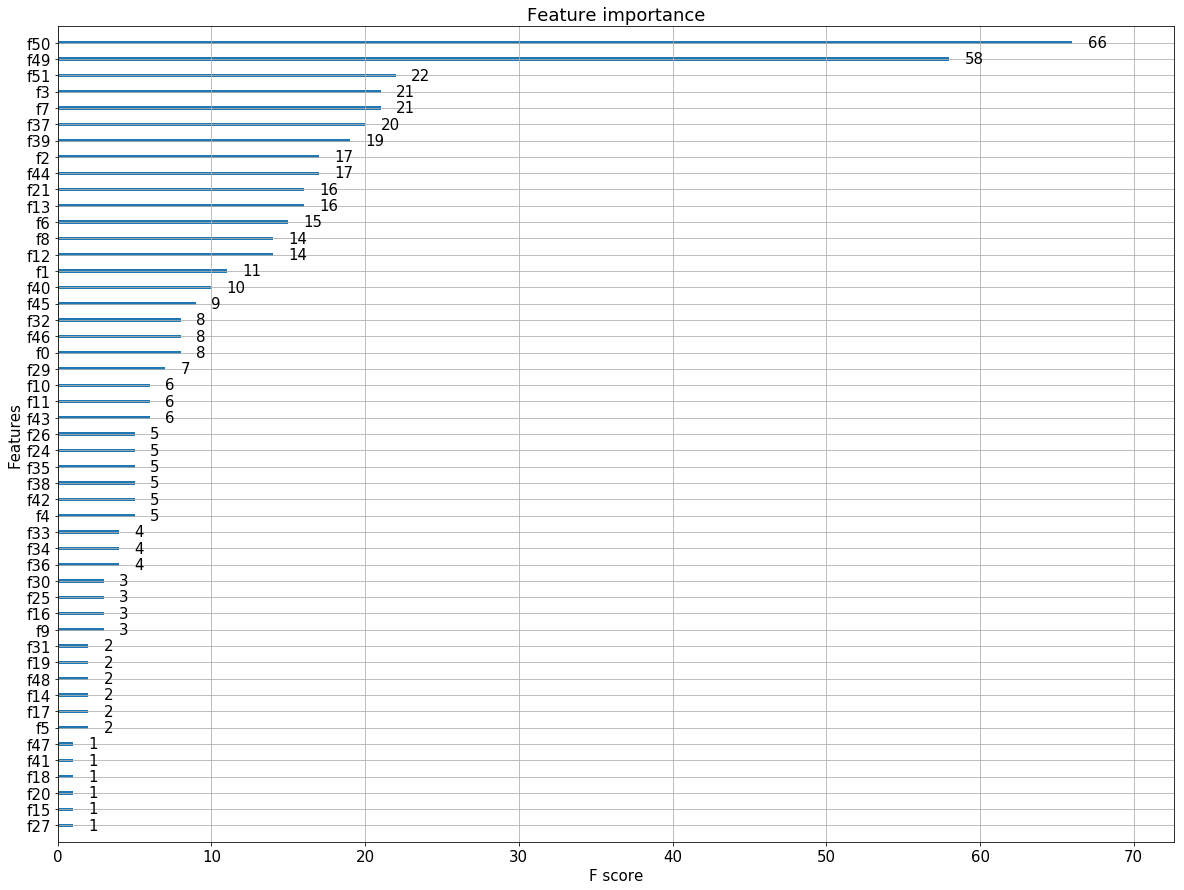

Thresh_test=0.000, n=52, Accuracy_test: 91.75%
Thresh_test=0.000, n=52, Accuracy_test: 91.75%
Thresh_test=0.000, n=52, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.002, n=49, Accuracy_test: 91.75%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.004, n=43, Accuracy_test: 93.20%
Thresh_test=0.006, n=37, Accuracy_test: 91.75%
Thresh_test=0.006, n=37, Accuracy_test: 91.75%
Thresh_test=0.006, n=37, Accuracy_test: 91.75%
Thresh_test=0.006, n=37, Accuracy_test: 91.75%
Thresh_test=0.008, n=33, Accuracy_test: 91.50%
Thresh_test=0.008, n=33, Accuracy_test: 91.50%
Thresh_test=0

In [36]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred_test = clf.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy_test: %.2f%%" % (accuracy * 100.0))
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.size'] = 15
plt.figure(figsize=(20,15))
plot_importance(clf,importance_type="weight", ax=plt.gca())
plt.show()
# Fit model using each importance as a threshold
thresholds = np.sort(clf.feature_importances_)
test = []
feat = []
for thresh in thresholds:
	# select features using threshold
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
# train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
#     print(selection.get_support(indices=1))
    feat.append(select_X_train.shape[1])
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred_test = selection_model.predict(select_X_test)
    predictions_test = [round(value) for value in y_pred_test]
    accuracy_test = accuracy_score(y_test, predictions_test)
    test.append(accuracy_test*100.0)
    print("Thresh_test=%.3f, n=%d, Accuracy_test: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_test*100.0))

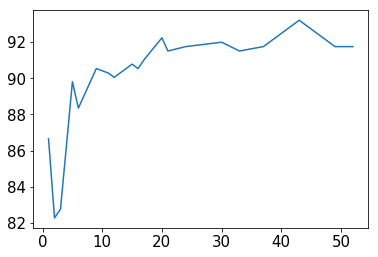

In [37]:
plt.plot(feat,test)
plt.show()

In [14]:
# clf2 = CatBoostClassifier(logging_level = "Silent")
# total = 0
# kappa = 0
# clf2.fit(X_train, y_train)
# # make predictions for test data and evaluate
# y_pred_test = clf2.predict(X_test)
# predictions_test = [round(value) for value in y_pred_test]
# accuracy = accuracy_score(y_test, predictions_test)
# print("Accuracy_test: %.2f%%" % (accuracy * 100.0))
# thresholds = np.sort(clf2.feature_importances_)
# test = []
# feat = []
# for thresh in thresholds:
# 	# select features using threshold
#     selection = SelectFromModel( clf2,threshold=thresh, prefit=True)
# #     print(selection.get_support(indices=1))
#     select_X_train = selection.transform(X_train)
# # train model
#     selection_model =  CatBoostClassifier(logging_level = "Silent")
#     selection_model.fit(select_X_train, y_train)
    
#     feat.append(select_X_train.shape[1])
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred_test = selection_model.predict(select_X_test)
#     predictions_test = [round(value) for value in y_pred_test]
#     accuracy_test = accuracy_score(y_test, predictions_test)
#     test.append(accuracy_test*100.0)
#     print("Thresh_test=%.3f, n=%d, Accuracy_test: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_test*100.0))

In [15]:
# plt.plot(feat,test)
# plt.show()

Accuracy_test: 91.50%


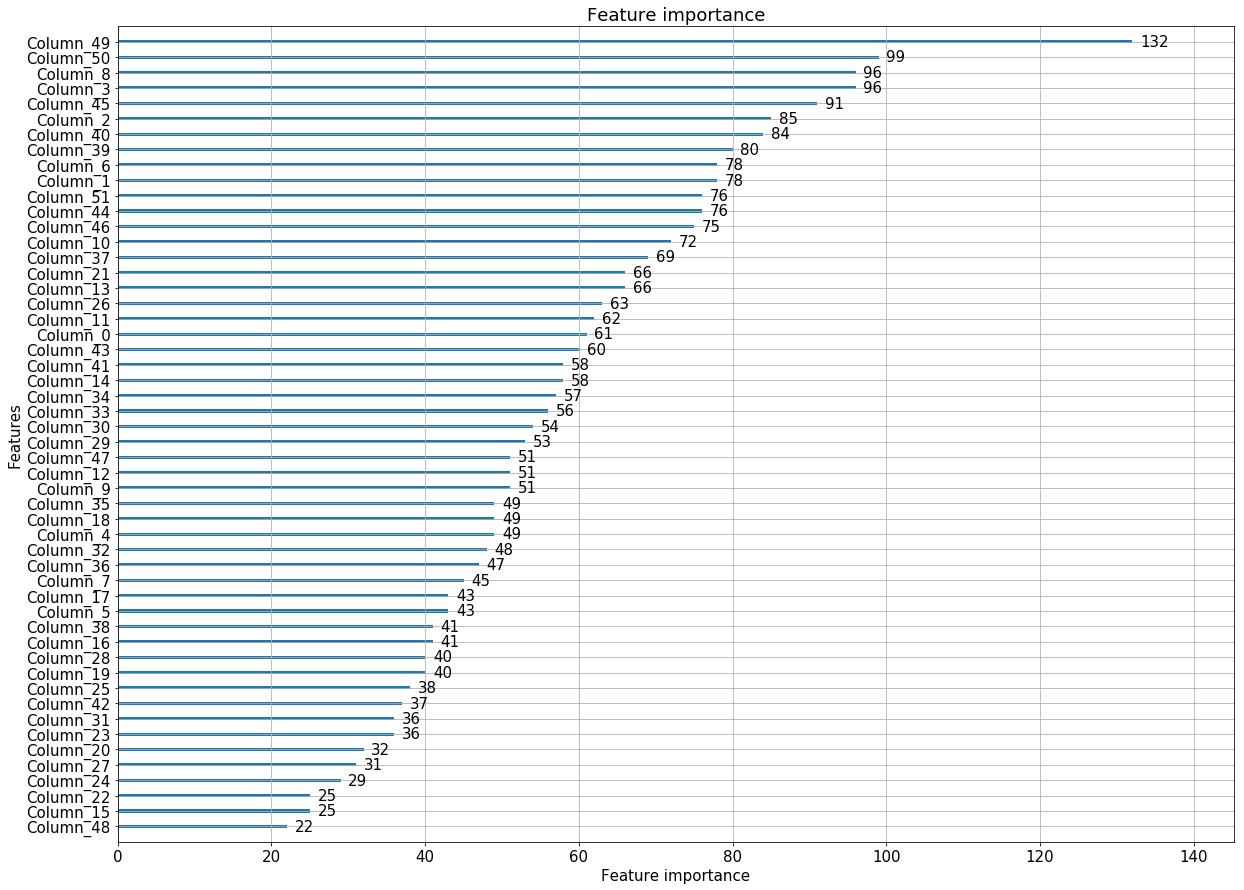

Thresh_test=22.000, n=52, Accuracy_test: 91.50%
Thresh_test=25.000, n=51, Accuracy_test: 91.99%
Thresh_test=25.000, n=51, Accuracy_test: 91.99%
Thresh_test=29.000, n=49, Accuracy_test: 91.50%
Thresh_test=31.000, n=48, Accuracy_test: 91.26%
Thresh_test=32.000, n=47, Accuracy_test: 92.23%
Thresh_test=36.000, n=46, Accuracy_test: 91.50%
Thresh_test=36.000, n=46, Accuracy_test: 91.50%
Thresh_test=37.000, n=44, Accuracy_test: 92.48%
Thresh_test=38.000, n=43, Accuracy_test: 91.26%
Thresh_test=40.000, n=42, Accuracy_test: 91.50%
Thresh_test=40.000, n=42, Accuracy_test: 91.50%
Thresh_test=41.000, n=40, Accuracy_test: 91.02%
Thresh_test=41.000, n=40, Accuracy_test: 91.02%
Thresh_test=43.000, n=38, Accuracy_test: 91.75%
Thresh_test=43.000, n=38, Accuracy_test: 91.75%
Thresh_test=45.000, n=36, Accuracy_test: 91.26%
Thresh_test=47.000, n=35, Accuracy_test: 90.53%
Thresh_test=48.000, n=34, Accuracy_test: 92.23%
Thresh_test=49.000, n=33, Accuracy_test: 91.26%
Thresh_test=49.000, n=33, Accuracy_test:

In [38]:
clf3 = LGBMClassifier()
total = 0
kappa = 0
clf3.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred_test = clf3.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy_test: %.2f%%" % (accuracy * 100.0))
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.size'] = 15
plt.figure(figsize=(20,15))
lightgbm.plot_importance(clf3, ax=plt.gca())
plt.show()
thresholds = np.sort(clf3.feature_importances_)
test = []
feat = []
for thresh in thresholds:
	# select features using threshold
    selection = SelectFromModel( clf3,threshold=thresh, prefit=True)
#     print(selection.get_support(indices=1))
    select_X_train = selection.transform(X_train)
# train model
    selection_model = LGBMClassifier()
    selection_model.fit(select_X_train, y_train)
    
    feat.append(select_X_train.shape[1])
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred_test = selection_model.predict(select_X_test)
    predictions_test = [round(value) for value in y_pred_test]
    accuracy_test = accuracy_score(y_test, predictions_test)
    test.append(accuracy_test*100.0)
    print("Thresh_test=%.3f, n=%d, Accuracy_test: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_test*100.0))

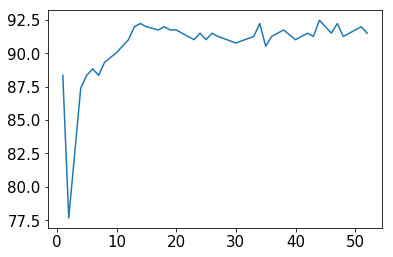

In [71]:
plt.plot(feat,test)
plt.show()

In [35]:
classifiers = [
    
#     KNeighborsClassifier(5),
    #DecisionTreeClassifier(max_depth=20),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1),
    #AdaBoostClassifier(),
   XGBClassifier(),
#     SVC(kernel='rbf',probability=True)
    CatBoostClassifier(logging_level = "Silent"),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    LGBMClassifier(),
]
#clf = AdaBoostClassifier()
clas = 0 
score = 0
total = 0
kappa = 0
extensions = ['none','mean','std','min','max', 'mean,std,min,max']
# extensions = ['none']
for clf in classifiers:  
    clas = clas + 1
    print("classifier", clas, "is running")
    for ext in extensions:
        o_sens,o_fpr = 0,0
        o2_sens,o3_sens,o4_sens,o5_sens,o6_sens = 0,0,0,0,0
        o2_fpr,o3_fpr,o4_fpr,o5_fpr,o6_fpr = 0,0,0,0,0
        j = 0
        r = []
        
        #i is customer meter number range

        for i in range(1001,1055):
            try:
                dataframe = create_complete_dataset(i)
                print("------------------------- customer =",i,", synth feat/s =",ext,"---------------------------------------------------")
                X__,y__ = generate_x_y_dataset(dataframe, ext)
                X_res_train, y_res_train,X_res_test, y_res_test = create_train_test(X__,y__ )
                sens, fpr = classfication(X_res_train, y_res_train,X_res_test, y_res_test, clf, total, kappa ) 
                o_sens = sens + o_sens
                o_fpr = fpr + o_fpr
                j = j + 1
                print("-------------------------------------------------------------------------------------------------------------------")
            except:
                print(i, ": data not available")
                r.append(i)
                continue
        if j != 0:
            print("-------------------------------------------------------------------------------------------------------------------")
            print("avg sensitivity for",j,"customers is:", o_sens*100.0/j,"synth feature/s:",ext)
            print("avg fpr for",j,"customers is:", o_fpr*100.0/j)
            print("-------------------------------------------------------------------------------------------------------------------")


classifier 1 is running
------------------------- customer = 1001 , synth feat/s = none ---------------------------------------------------
sensi = 87.73841961852861 fpr=  13.351498637602177
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1002 , synth feat/s = none ---------------------------------------------------
sensi = 97.00272479564033 fpr=  1.6348773841961872
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1003 , synth feat/s = none ---------------------------------------------------
sensi = 88.5558583106267 fpr=  17.983651226158038
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1004 , synth feat/s = none ---------------------------------------------------
sensi = 89.9

------------------------- customer = 1005 , synth feat/s = mean ---------------------------------------------------
sensi = 98.36512261580381 fpr=  3.2697547683923744
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1006 , synth feat/s = mean ---------------------------------------------------
sensi = 96.18528610354224 fpr=  2.7247956403269713
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1007 , synth feat/s = mean ---------------------------------------------------
sensi = 89.91825613079018 fpr=  10.899182561307907
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1008 , synth feat/s = mean ---------------------------------------------------
sensi = 97.00272479564033 fpr=  7.3

sensi = 92.64305177111717 fpr=  5.722070844686645
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1010 , synth feat/s = std ---------------------------------------------------
sensi = 93.18801089918256 fpr=  5.722070844686645
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1011 , synth feat/s = std ---------------------------------------------------
sensi = 93.82352941176471 fpr=  5.882352941176472
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1012 , synth feat/s = std ---------------------------------------------------
1012 : data not available
------------------------- customer = 1013 , synth feat/s = std ---------------------------------------------------
sensi = 98.63760

sensi = 98.63760217983652 fpr=  1.6348773841961872
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1015 , synth feat/s = min ---------------------------------------------------
sensi = 98.36512261580381 fpr=  1.3623978201634857
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1016 , synth feat/s = min ---------------------------------------------------
sensi = 83.37874659400545 fpr=  12.806539509536785
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1017 , synth feat/s = min ---------------------------------------------------
sensi = 98.09264305177112 fpr=  7.629427792915533
--------------------------------------------------------------------------------------------------------

------------------------- customer = 1019 , synth feat/s = max ---------------------------------------------------
sensi = 89.64577656675749 fpr=  10.081743869209813
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1020 , synth feat/s = max ---------------------------------------------------
sensi = 90.46321525885558 fpr=  2.997275204359673
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1021 , synth feat/s = max ---------------------------------------------------
sensi = 83.37874659400545 fpr=  20.98092643051771
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1022 , synth feat/s = max ---------------------------------------------------
sensi = 99.72752043596729 fpr=  0.0
-----

------------------------- customer = 1023 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 94.27792915531336 fpr=  0.8174386920980936
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1024 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 98.63760217983652 fpr=  2.452316076294281
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1025 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 88.28337874659401 fpr=  15.531335149863757
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1026 , synth feat/s = mean,std,min,max ----------------------------------------

-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1024 , synth feat/s = none ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.36512261580381 fpr=  2.1798365122615793
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1025 , synth feat/s = none ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.36512261580381 fpr=  17.438692098092645
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1026 , synth feat/s = none ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.9100817438692 fpr=  10.354223433242504
--------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1023 , synth feat/s = mean ---------------------------------------------------
Learning rate set to 0.025326
sensi = 92.64305177111717 fpr=  14.16893732970027
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1024 , synth feat/s = mean ---------------------------------------------------
Learning rate set to 0.025326
sensi = 91.82561307901908 fpr=  13.623978201634879
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1025 , synth feat/s = mean ---------------------------------------------------
Learning rate set to 0.025326
sensi = 94.82288828337875 fpr=  27.520435967302447
--------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1022 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 100.0 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1023 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 95.36784741144415 fpr=  0.544959128065392
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1024 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.9100817438692 fpr=  1.0899182561307952
---------------------------------------------------------------------------------------------

sensi = 100.0 fpr=  0.544959128065392
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1050 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.9100817438692 fpr=  1.9073569482288777
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1051 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 99.72752043596729 fpr=  0.8174386920980936
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1052 , synth feat/s = std ---------------------------------------------------
Learning rate set to 0.025326
sensi = 98.63760217983652 fpr=  2.7247956403269713
---------------------------

------------------------- customer = 1048 , synth feat/s = min ---------------------------------------------------
1048 : data not available
------------------------- customer = 1049 , synth feat/s = min ---------------------------------------------------
Learning rate set to 0.025326
sensi = 97.82016348773843 fpr=  4.087193460490468
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1050 , synth feat/s = min ---------------------------------------------------
Learning rate set to 0.025326
sensi = 91.82561307901908 fpr=  2.997275204359673
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1051 , synth feat/s = min ---------------------------------------------------
Learning rate set to 0.025326
sensi = 99.45504087193461 fpr=  0.544959128065392
------------------------------------------

sensi = 99.72752043596729 fpr=  1.6348773841961872
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1021 , synth feat/s = max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 94.27792915531336 fpr=  22.615803814713896
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1022 , synth feat/s = max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 100.0 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1023 , synth feat/s = max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 93.18801089918256 fpr=  13.079019073569487
----------------------------------------

------------------------- customer = 1019 , synth feat/s = mean,std,min,max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 100.0 fpr=  2.452316076294281
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1020 , synth feat/s = mean,std,min,max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 92.91553133514986 fpr=  6.811989100817439
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1021 , synth feat/s = mean,std,min,max ---------------------------------------------------
Learning rate set to 0.025326
sensi = 97.54768392370572 fpr=  23.16076294277929
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 102

sensi = 97.00272479564033 fpr=  2.997275204359673
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1019 , synth feat/s = none ---------------------------------------------------
sensi = 97.54768392370572 fpr=  11.171662125340598
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1020 , synth feat/s = none ---------------------------------------------------
sensi = 99.1825613079019 fpr=  6.267029972752047
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1021 , synth feat/s = none ---------------------------------------------------
sensi = 95.36784741144415 fpr=  31.607629427792915
-------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1023 , synth feat/s = mean ---------------------------------------------------
sensi = 97.82016348773843 fpr=  11.71662125340599
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1024 , synth feat/s = mean ---------------------------------------------------
sensi = 96.73024523160763 fpr=  8.174386920980925
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1025 , synth feat/s = mean ---------------------------------------------------
sensi = 95.91280653950953 fpr=  26.975476839237057
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 

------------------------- customer = 1027 , synth feat/s = std ---------------------------------------------------
sensi = 100.0 fpr=  2.1798365122615793
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1028 , synth feat/s = std ---------------------------------------------------
sensi = 96.73024523160763 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1029 , synth feat/s = std ---------------------------------------------------
sensi = 98.63760217983652 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1030 , synth feat/s = std ---------------------------------------------------
sensi = 96.17647058823529 fpr=  6.470588235294117
-------------------------------

-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1032 , synth feat/s = min ---------------------------------------------------
sensi = 99.72752043596729 fpr=  14.16893732970027
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1033 , synth feat/s = min ---------------------------------------------------
sensi = 99.72752043596729 fpr=  5.449591280653953
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1034 , synth feat/s = min ---------------------------------------------------
sensi = 99.72752043596729 fpr=  2.452316076294281
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1035

------------------------- customer = 1036 , synth feat/s = max ---------------------------------------------------
sensi = 98.9100817438692 fpr=  2.1798365122615793
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1037 , synth feat/s = max ---------------------------------------------------
sensi = 97.54768392370572 fpr=  4.087193460490468
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1038 , synth feat/s = max ---------------------------------------------------
sensi = 100.0 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1039 , synth feat/s = max ---------------------------------------------------
sensi = 99.72752043596729 fpr=  0.8174386920980936
-----------------

------------------------- customer = 1039 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 100.0 fpr=  0.0
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1040 , synth feat/s = mean,std,min,max ---------------------------------------------------
1040 : data not available
------------------------- customer = 1041 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 98.36512261580381 fpr=  3.2697547683923744
-------------------------------------------------------------------------------------------------------------------
------------------------- customer = 1042 , synth feat/s = mean,std,min,max ---------------------------------------------------
sensi = 98.09264305177112 fpr=  4.3596730245231585
--------------------------------------------------------------------------------------------------------

In [19]:
print("hi")

hi


In [20]:
def f(i1,i2,kappa):
    score = 0
    total = 0
    clf = XGBClassifier()
    o_sens,o_fpr = 0,0
    o2_sens,o3_sens,o4_sens,o5_sens,o6_sens = 0,0,0,0,0
    o2_fpr,o3_fpr,o4_fpr,o5_fpr,o6_fpr = 0,0,0,0,0
    j = 0
    r = []
    #     ext = 'none'
    # ext = 'mean'
    # ext = 'std'
    # ext = 'min'
    # ext = 'max'
    ext = 'mean,std,min,max'
    #i is customer meter number range
    for i in range(i1,i2):
        try:
            dataframe = create_complete_dataset(i)
            print("------------------------- customer =",i,", synth feat/s =",ext,"---------------------------------------------------")
            X__,y__ = generate_x_y_dataset(dataframe, ext)
            X_res_train, y_res_train,X_res_test, y_res_test = create_train_test(X__,y__ )
            sens, fpr = classfication(X_res_train, y_res_train,X_res_test, y_res_test, clf, total, kappa ) 
            o_sens = sens + o_sens
            o_fpr = fpr + o_fpr
            j = j + 1
            print("-------------------------------------------------------------------------------------------------------------------")
        except:
            print(i, ": data not available")
            r.append(i)
            continue
    if j != 0:
        print("-------------------------------------------------------------------------------------------------------------------")
        print("avg sensitivity for",j,"customers is:", o_sens/j,"synth feature/s:",ext)
        print("avg fpr for",j,"customers is:", o_fpr/j)
        print("-------------------------------------------------------------------------------------------------------------------")


In [21]:
a1 = widgets.IntText(
    value=0,
    description='0 or 1 or 2',
    disabled=False
)

b = widgets.Button(
    description='click'
)
slide = widgets.IntRangeSlider(
    value=[1001, 1002],
    min=1001,
    max=2000,
    step=1,
    description='meter no.:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
display(a1,b,slide)
def on_button_clicked(b):
    f(slide.value[0],slide.value[1],a1.value)
b.on_click(on_button_clicked)

IntText(value=0, description='0 or 1 or 2')

Button(description='click', style=ButtonStyle())

IntRangeSlider(value=(1001, 1002), continuous_update=False, description='meter no.:', max=2000, min=1001)

In [22]:
customer_number = data[data['meter'] == 1003]
customer_number = customer_number.sort_values(by=['day'])
del customer_number['meter']
del customer_number['date']
customer_number.set_index('day', inplace=True)
j =0
p = (random.randint(1,9))/10
X_ = np.array([]).reshape(0,48)
y_ = np.array([])
b=customer_number.loc[195].sort_values(by=['time']).iloc[:,0]
t1 =  np.array([x * p for x in b])
t2 = np.array([z * (random.randint(1,10))/10 for z in b])
t3 = np.array([y * (random.randint(0,1)) for y in b])
t4 =  np.array([np.mean(b)*(random.randint(1,10))/10 for z in b])
t5 =  np.array([np.mean(b) for t in b])
t6 = b[::-1]

In [23]:
# rp1.xaxis.major_label_text_font_size = '30pt'  
# rp1.yaxis.major_label_text_font_size = '30pt'
# rp1.xaxis.axis_label_text_font_size = "30pt"
# rp1.yaxis.axis_label_text_font_size = "30pt"
# rp1.yaxis.axis_label_text_font_style = "bold"
# rp1.xaxis.axis_label_text_font_style = "bold"
# rp1.legend.label_text_font_style = "bold"
# rp2.xaxis.major_label_text_font_size = '30pt'  
# rp2.yaxis.major_label_text_font_size = '30pt'
# rp2.xaxis.axis_label_text_font_size = "30pt"
# rp2.yaxis.axis_label_text_font_size = "30pt"
# rp2.yaxis.axis_label_text_font_style = "bold"
# rp2.xaxis.axis_label_text_font_style = "bold"
# rp2.legend.label_text_font_style = "bold"
# rp3.xaxis.major_label_text_font_size = '30pt'  
# rp3.yaxis.major_label_text_font_size = '30pt'
# rp3.xaxis.axis_label_text_font_size = "30pt"
# rp3.yaxis.axis_label_text_font_size = "30pt"
# rp3.yaxis.axis_label_text_font_style = "bold"
# rp3.xaxis.axis_label_text_font_style = "bold"
# rp3.legend.label_text_font_style = "bold"
# rp4.xaxis.major_label_text_font_size = '30pt'  
# rp4.yaxis.major_label_text_font_size = '30pt'
# rp4.xaxis.axis_label_text_font_size = "30pt"
# rp4.yaxis.axis_label_text_font_size = "30pt"
# rp4.yaxis.axis_label_text_font_style = "bold"
# rp4.xaxis.axis_label_text_font_style = "bold"
# rp4.legend.label_text_font_style = "bold"
# rp5.xaxis.major_label_text_font_size = '30pt'  
# rp5.yaxis.major_label_text_font_size = '30pt'
# rp5.xaxis.axis_label_text_font_size = "30pt"
# rp5.yaxis.axis_label_text_font_size = "30pt"
# rp5.yaxis.axis_label_text_font_style = "bold"
# rp5.xaxis.axis_label_text_font_style = "bold"
# rp5.legend.label_text_font_style = "bold"
# rp6.xaxis.major_label_text_font_size = '30pt'  
# rp6.yaxis.major_label_text_font_size = '30pt'
# rp6.xaxis.axis_label_text_font_size = "30pt"
# rp6.yaxis.axis_label_text_font_size = "30pt"
# rp6.yaxis.axis_label_text_font_style = "bold"
# rp6.xaxis.axis_label_text_font_style = "bold"
# rp6.legend.label_text_font_style = "bold"

rp = figure(plot_height=100,plot_width=960)
rp.line(np.arange(0,len(b)),b,line_width=2,line_color=Dark2[7][1],legend="real")

rp1 = figure(plot_height=100,plot_width=960)
rp1.line(np.arange(0,len(t1)),t1,line_width=2,line_color=Dark2[7][2],legend="theft 1")
rp1.cross(np.arange(0,len(t1)),t1,legend="theft 1",size = 5)

rp2 = figure(plot_height=100,plot_width=960)
rp2.line(np.arange(0,len(t2)),t2,line_width=2,line_color=Dark2[7][3],legend="theft 2")
rp2.diamond(np.arange(0,len(t2)),t2,legend="theft 2",size = 5)

rp3 = figure(plot_height=100,plot_width=960)
rp3.line(np.arange(0,len(t3)),t3,line_width=2,line_color=Dark2[7][4],legend="theft 3")
rp3.circle(np.arange(0,len(t3)),t3,legend="theft 3",size = 5)

rp4 = figure(plot_height=100,plot_width=960)
rp4.line(np.arange(0,len(t4)),t4,line_width=2,line_color=Dark2[7][5],legend="theft 4")
rp4.square(np.arange(0,len(t4)),t4,legend="theft 4",size = 5)

rp5 = figure(plot_height=100,plot_width=960)
rp5.line(np.arange(0,len(t5)),t5,line_width=2,line_color=Dark2[7][6],legend="theft 5")
rp5.triangle(np.arange(0,len(t5)),t5,legend="theft 5",size = 5)

rp6 = figure(plot_height=100,plot_width=960)
rp6.line(np.arange(0,len(t6)),t6,line_width=2,line_color=Dark2[7][0],legend="theft 6",line_dash =[4,4])

# rp.legend.location ="top_center"
rp.legend.label_text_font_size = "15pt"
rp.legend.orientation = "horizontal"
rp.legend.border_line_width = 1
rp.legend.border_line_color = "black"
rp.legend.border_line_alpha = 1
# rp1.legend.location ="top_center"
rp1.legend.label_text_font_size = "15pt"
rp1.legend.orientation = "horizontal"
rp1.legend.border_line_width = 1
rp1.legend.border_line_color = "black"
rp1.legend.border_line_alpha = 1
# rp2.legend.location ="top_center"
rp2.legend.label_text_font_size = "15pt"
rp2.legend.orientation = "horizontal"
rp2.legend.border_line_width = 1
rp2.legend.border_line_color = "black"
rp2.legend.border_line_alpha = 1
# rp3.legend.location ="top_center"
rp3.legend.label_text_font_size = "15pt"
rp3.legend.orientation = "horizontal"
rp3.legend.border_line_width = 1
rp3.legend.border_line_color = "black"
rp3.legend.border_line_alpha = 1
# rp4.legend.location ="top_center"
rp4.legend.label_text_font_size = "15pt"
rp4.legend.orientation = "horizontal"
rp4.legend.border_line_width = 1
rp4.legend.border_line_color = "black"
rp4.legend.border_line_alpha = 1
# rp5.legend.location ="top_center"
rp5.legend.label_text_font_size = "15pt"
rp5.legend.orientation = "horizontal"
rp5.legend.border_line_width = 1
rp5.legend.border_line_color = "black"
rp5.legend.border_line_alpha = 1
# rp6.legend.location ="top_center"
rp6.legend.label_text_font_size = "15pt"
rp6.legend.orientation = "horizontal"
rp6.legend.border_line_width = 1
rp6.legend.border_line_color = "black"
rp6.legend.border_line_alpha = 1
grid = gridplot([rp,rp1,rp2,rp3,rp4,rp5,rp6], ncols=1)
show(grid)

In [24]:
# customer_number.loc[205].sort_values(by=['time']).plot(figsize=(24, 4), x='time',y='usage', label = 'real')
rp = figure(plot_height=300,plot_width=960,x_axis_label='t',y_axis_label='power usage (kw)')
rp.xaxis.major_label_text_font_size = '18pt'  # turn off x-axis tick labels
rp.yaxis.major_label_text_font_size = '18pt'
rp.xaxis.axis_label_text_font_size = "18pt"
rp.yaxis.axis_label_text_font_size = "18pt"
rp.yaxis.axis_label_text_font_style = "bold"
rp.xaxis.axis_label_text_font_style = "bold"
rp.legend.label_text_font_style = "bold"
rp.line(np.arange(0,len(b)),b,line_width=3,line_color=Dark2[7][1],legend="real")
rp.line(np.arange(0,len(t1)),t1,line_width=3,line_color=Dark2[7][2],legend="theft 1")
rp.cross(np.arange(0,len(t1)),t1,line_color=Dark2[7][2],legend="theft 1",size = 6)
rp.line(np.arange(0,len(t2)),t2,line_width=3,line_color=Dark2[7][3],legend="theft 2")
rp.diamond(np.arange(0,len(t2)),t2,line_color=Dark2[7][3],legend="theft 2",size = 6)
rp.line(np.arange(0,len(t3)),t3,line_width=3,line_color=Dark2[7][4],legend="theft 3")
rp.circle(np.arange(0,len(t3)),t3,line_color=Dark2[7][4],legend="theft 3",size = 6)
rp.line(np.arange(0,len(t4)),t4,line_width=3,line_color=Dark2[7][5],legend="theft 4")
rp.square(np.arange(0,len(t4)),t4,line_color=Dark2[7][5],legend="theft 4",size = 6)
rp.line(np.arange(0,len(t5)),t5,line_width=3,line_color=Dark2[7][6],legend="theft 5")
rp.triangle(np.arange(0,len(t5)),t5,line_color=Dark2[7][6],legend="theft 5",size =6)
rp.line(np.arange(0,len(t6)),t6,line_width=3,line_color=Dark2[7][0],legend="theft 6",line_dash =[4,4])

rp.legend.location ="top_right"
rp.legend.label_text_font_size = "15pt"
rp.legend.orientation = "horizontal"
rp.legend.border_line_width = 1
rp.legend.border_line_alpha = 1
rp.legend.border_line_color = "black"
rp.legend.background_fill_alpha = 0.5
show(rp)

In [25]:
# customer_number.loc[205].sort_values(by=['time']).plot(figsize=(24, 4), x='time',y='usage', label = 'real')
rp = figure(plot_height=200,plot_width=960,x_axis_label='Time (sampling interval = 30 min)',y_axis_label='Power Usage (kw)')
rp.xaxis.major_label_text_font_size = '12pt'  # turn off x-axis tick labels
rp.yaxis.major_label_text_font_size = '12pt'
rp.xaxis.axis_label_text_font_size = "12pt"
rp.yaxis.axis_label_text_font_size = "12pt"
rp.yaxis.axis_label_text_font_style = "bold"
rp.xaxis.axis_label_text_font_style = "bold"
rp.legend.label_text_font_style = "bold"
rp.line(np.arange(0,len(b)),b,line_width=1,line_color=Spectral11[1],legend="real")
rp.line(np.arange(0,len(t1)),t1,line_color=Spectral11[2],legend="theft 1")
rp.line(np.arange(0,len(t2)),t2,line_color=Spectral11[3],legend="theft 2")
rp.line(np.arange(0,len(t3)),t3,line_color=Spectral11[7],legend="theft 3")
rp.line(np.arange(0,len(t4)),t4,line_color=Spectral11[4],legend="theft 4")
rp.line(np.arange(0,len(t5)),t5,line_color=Spectral11[0],legend="theft 5")
rp.line(np.arange(0,len(t6)),t6,line_color=Spectral11[10],legend="theft 6")
rp.legend.location ="top_center"
rp.legend.label_text_font_size = "10pt"
rp.legend.orientation = "horizontal"
show(rp)

In [26]:
rp = figure(plot_height=300,plot_width=960,x_axis_label='t',y_axis_label='power usage (kw)')
# create a new line chat with a title and axis labels
rp.xaxis.major_label_text_font_size = '20pt'  # turn off x-axis tick labels
rp.yaxis.major_label_text_font_size = '20pt'
rp.xaxis.axis_label_text_font_size = "20pt"
rp.yaxis.axis_label_text_font_size = "20pt"
rp.yaxis.axis_label_text_font_style = "bold"
rp.xaxis.axis_label_text_font_style = "bold"
rp.legend.label_text_font_style = "bold"
rp.line(np.arange(0,len(b)),b,line_width=3,line_color=Spectral11[1],legend="real usage")
rp.legend.location ="top_left"
rp.legend.label_text_font_size = "18pt"
rp.legend.orientation = "vertical"
rp.legend.border_line_width = 1
rp.legend.border_line_color = "black"
rp.legend.border_line_alpha = 1
show(rp)

Accuracy: 98.82%


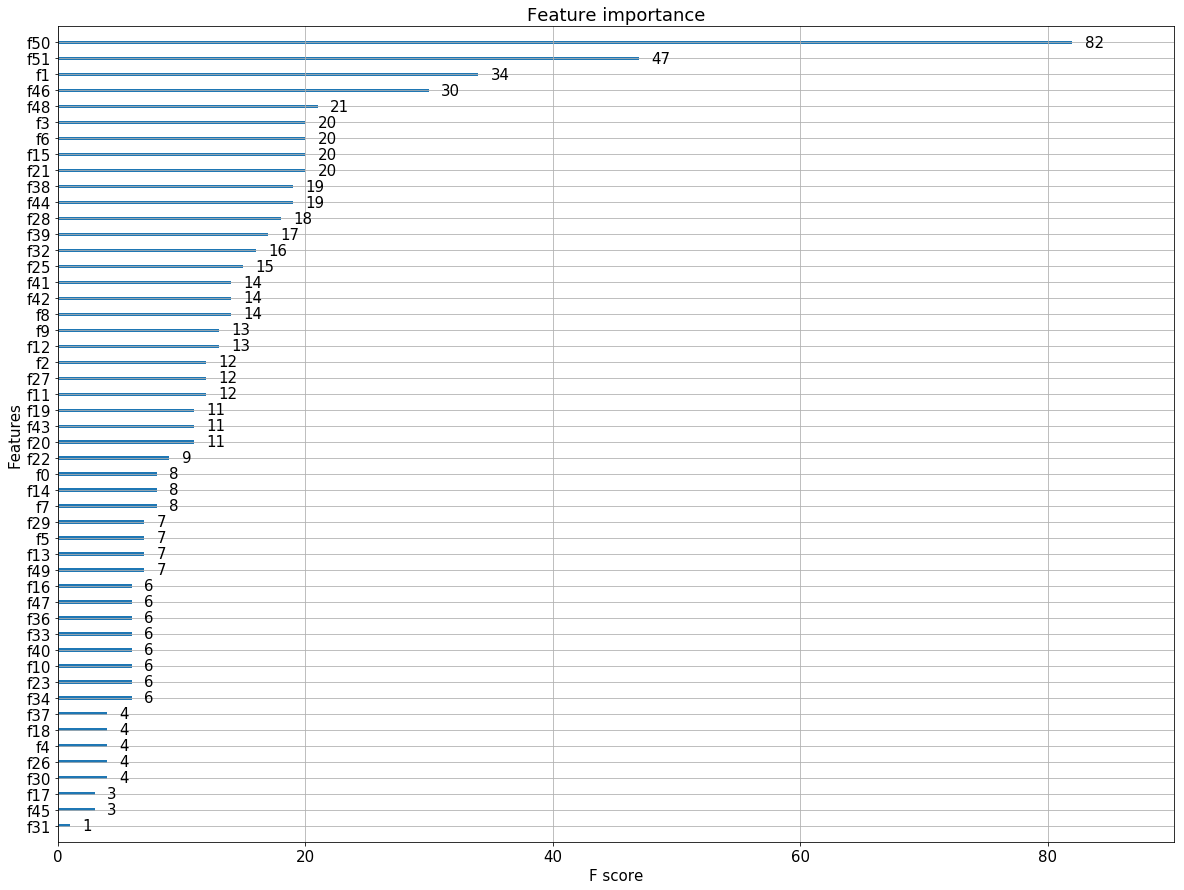

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Thresh=0.000, n=52, Accuracy: 98.82%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Thresh=0.000, n=52, Accuracy: 98.82%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
Thresh=0.001, n=50, Accuracy: 98.82%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51]
Thresh=0.004, n=49, Accuracy: 98.82%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51]
Thresh=0.004, n=49, Accuracy: 98.82%
[ 0  1  2  3  4  5  6  7  8  9 10 11 12

In [27]:
from sklearn.feature_selection import SelectFromModel
model = XGBClassifier()
# ext = 'none'
# ext = 'mean'
# ext = 'std'
# ext = 'min'
# ext = 'max'
ext = 'mean,std,min,max'
i = 1030
dataframe = create_complete_dataset(i)
X__,y__ = generate_x_y_dataset(dataframe, ext)
X_res_train, y_res_train,X_res_test, y_res_test = create_train_test(X__,y__ )
model.fit(X_res_train, y_res_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_res_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_res_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.size'] = 15
plt.figure(figsize=(20,15))
plot_importance(model,importance_type="weight", ax=plt.gca())
plt.show()
# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_res_train)
# train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_res_train)
    print(selection.get_support(indices=1))
    # eval model
    select_X_test = selection.transform(X_res_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_res_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [28]:
customer_number = data[data['meter'] == 1184]
customer_number = customer_number.sort_values(by=['day'])
del customer_number['meter']
del customer_number['date']
customer_number.set_index('day', inplace=True)
j =0
X = np.zeros(shape=(420*7,52))
y = np.zeros(shape=(420*7,)) 
p = (random.randint(1,9))/10
for i in range(195,195+420):
    b=customer_number.loc[i].sort_values(by=['time']).iloc[:,0]
    t1 =  np.array([x * p for x in b])
    t2 = np.array([z * (random.randint(1,10))/10 for z in b])
    t3 = np.array([y * (random.randint(0,1)) for y in b])
    t4 =  np.array([np.mean(b)*(random.randint(1,8))/10 for z in b])
    t5 =  np.array([np.mean(b) for t in b])
    t6 = b[::-1]
#     b = np.append(b,[b.std()])
#     t1 = np.append(t1,[t1.std()])
#     t2 = np.append(t2,[t2.std()])
#     t3 = np.append(t3,[t3.std()])
#     t4 = np.append(t4,[t4.std()])
#     t5 = np.append(t5,[t5.std()])
#     t6 = np.append(t6,[t6.std()])
    b = np.append(b,[b.mean(),b.std(),b.min(),b.max()])
    t1 = np.append(t1,[t1.mean(),t1.std(),t1.min(),t1.max()])
    t2 = np.append(t2,[t2.mean(),t2.std(),t2.min(),t2.max()])
    t3 = np.append(t3,[t3.mean(),t3.std(),t3.min(),t3.max()])
    t4 = np.append(t4,[t4.mean(),t4.std(),t4.min(),t4.max()])
    t5 = np.append(t5,[t5.mean(),t5.std(),t5.min(),t5.max()])
    t6 = np.append(t6,[t6.mean(),t6.std(),t6.min(),t6.max()])
#     b_ = np.append(b.mean(),b.std())
#     t1_ = np.append(t1.mean(),t1.std())
#     t2_ = np.append(t2.mean(),t2.std())
#     t3_ = np.append(t3.mean(),t3.std())
#     t4_ = np.append(t4.mean(),t4.std())
#     t5_ = np.append(t5.mean(),t5.std())
#     t6_ = np.append(t6.mean(),t6.std())
    X[j] = b
    y[j] = 0
    j= j+1
    X[j] = t1
    y[j] = 1
    j= j+1
    X[j] = t2
    y[j] = 1
    j= j+1
    X[j] = t3
    y[j] = 1
    j= j+1
    X[j] = t4
    y[j] = 1
    j= j+1
    X[j] = t5
    y[j] = 1
    j= j+1
    X[j] = t6
    y[j] = 1
    j= j+1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.14, random_state=0)
sm = SMOTE(random_state=42)
X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
X_res_test, y_res_test = sm.fit_sample(X_test, y_test)
dt = DMatrix(X_res_train, label=y_res_train)
dt.feature_names = [ 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'mean','std', 'min', 'max']
dv = DMatrix(X_res_test, label=y_res_test)
dv.feature_names = [ 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'mean','std', 'min', 'max']
params = {
"eta": 0.5,
"max_depth": 4,
"objective": "binary:logistic",
"silent": 1,
"base_score": np.mean(y_res_train),
"eval_metric": "logloss"
}
model = train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:0.437321	valid-logloss:0.451245
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[25]	train-logloss:0.063218	valid-logloss:0.226769
Stopping. Best iteration:
[21]	train-logloss:0.075025	valid-logloss:0.219195



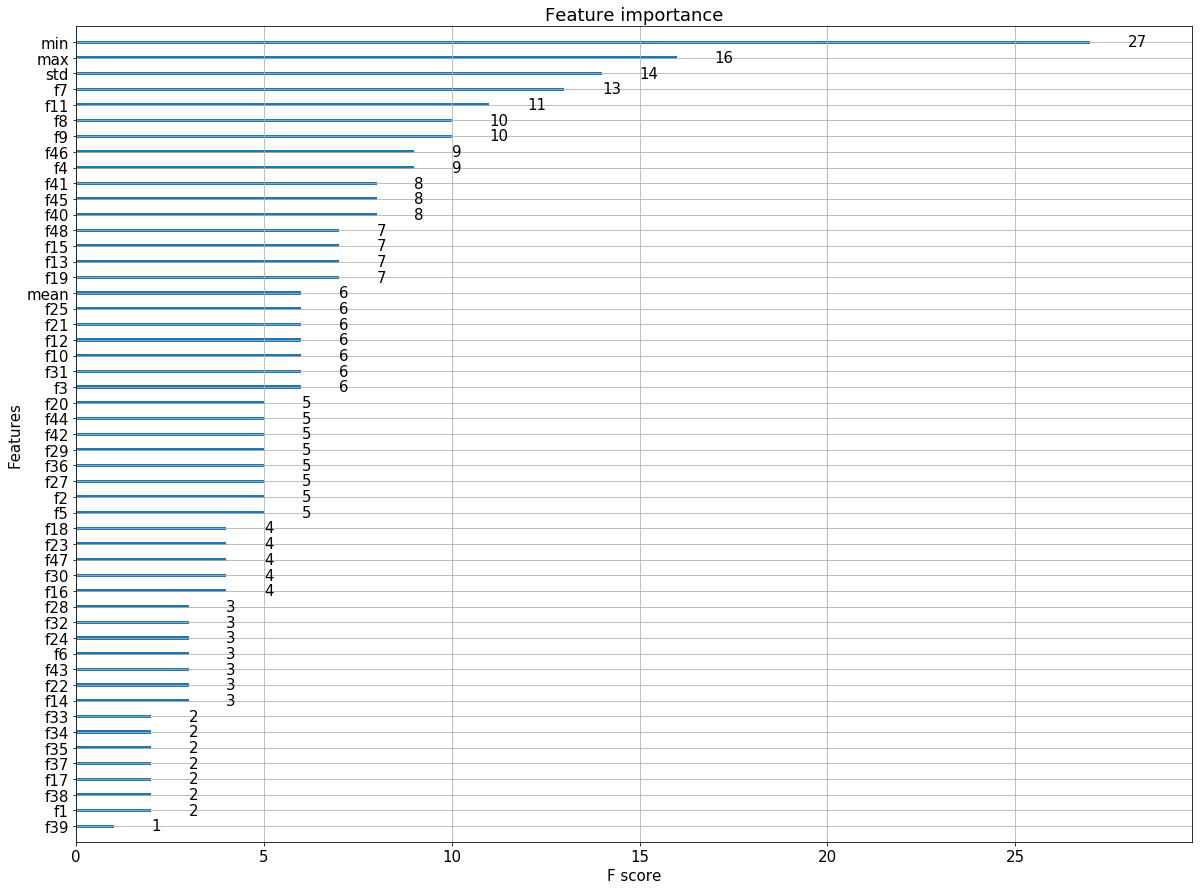

In [29]:
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.size'] = 15
plt.figure(figsize=(20,15))
plot_importance(model,importance_type="weight", ax=plt.gca())
plt.show()

In [30]:
shap_values = model.predict(dv, pred_contribs=True)

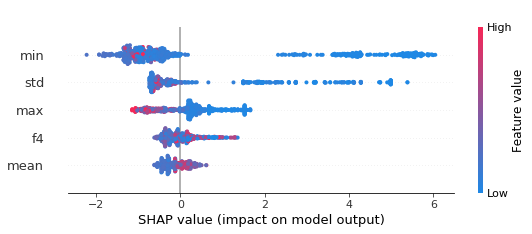

In [31]:
shap.summary_plot(shap_values, X_res_test,feature_names = dv.feature_names,plot_type ='dot',max_display =5,title='feature importance')

In [32]:
""" Plots for feature attributions.
"""

import warnings

import iml
import numpy as np
from iml import Instance, Model
from iml.datatypes import DenseData
from iml.explanations import AdditiveExplanation
from iml.links import IdentityLink
from scipy.stats import gaussian_kde

try:
    import matplotlib.pyplot as pl
    import matplotlib
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.ticker import MaxNLocator

    cdict1 = {
        'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
                (1.0, 0.9607843137254902, 0.9607843137254902)),

        'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
                  (1.0, 0.15294117647058825, 0.15294117647058825)),

        'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
                 (1.0, 0.3411764705882353, 0.3411764705882353)),

        'alpha': ((0.0, 1, 1),
                  (0.5, 0.3, 0.3),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue = LinearSegmentedColormap('RedBlue', cdict1)

    cdict1 = {
        'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
                (1.0, 0.9607843137254902, 0.9607843137254902)),

        'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
                  (1.0, 0.15294117647058825, 0.15294117647058825)),

        'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
                 (1.0, 0.3411764705882353, 0.3411764705882353)),

        'alpha': ((0.0, 1, 1),
                  (0.5, 1, 1),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)
except ImportError:
    pass

labels = {
    'MAIN_EFFECT': "SHAP main effect value for\n%s",
    'INTERACTION_VALUE': "SHAP interaction value",
    'INTERACTION_EFFECT': "SHAP interaction value for\n%s and %s",
    'VALUE': "SHAP value (impact on model output)",
    'VALUE_FOR': "SHAP value for\n%s",
    'PLOT_FOR': "SHAP plot for %s",
    'FEATURE': "Feature %s",
    'FEATURE_VALUE': "Feature value",
    'FEATURE_VALUE_LOW': "Low",
    'FEATURE_VALUE_HIGH': "High",
    'JOINT_VALUE': "Joint SHAP value"
}


# TODO: remove color argument / use color argument
def dependence_plot(ind, shap_values, features, feature_names=None, display_features=None,
                    interaction_index="auto", color="#1E88E5", axis_color="#333333",
                    dot_size=16, alpha=1, title=None, show=True):
    """
    Create a SHAP dependence plot, colored by an interaction feature.
    Parameters
    ----------
    ind : int
        Index of the feature to plot.
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)
    features : numpy.array or pandas.DataFrame
        Matrix of feature values (# samples x # features)
    feature_names : list
        Names of the features (length # features)
    display_features : numpy.array or pandas.DataFrame
        Matrix of feature values for visual display (such as strings instead of coded values)
    interaction_index : "auto", None, or int
        The index of the feature used to color the plot.
    """

    # convert from DataFrames if we got any
    if str(type(features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    if str(type(display_features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = display_features.columns
        display_features = display_features.values
    elif display_features is None:
        display_features = features

    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1] - 1)]

    # allow vectors to be passed
    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, len(shap_values), 1)
    if len(features.shape) == 1:
        features = np.reshape(features, len(features), 1)

    def convert_name(ind):
        if type(ind) == str:
            nzinds = np.where(feature_names == ind)[0]
            if len(nzinds) == 0:
                print("Could not find feature named: " + ind)
                return None
            else:
                return nzinds[0]
        else:
            return ind

    ind = convert_name(ind)

    # plotting SHAP interaction values
    if len(shap_values.shape) == 3 and len(ind) == 2:
        ind1 = convert_name(ind[0])
        ind2 = convert_name(ind[1])
        if ind1 == ind2:
            proj_shap_values = shap_values[:, ind2, :]
        else:
            proj_shap_values = shap_values[:, ind2, :] * 2  # off-diag values are split in half

        # TODO: remove recursion; generally the functions should be shorter for more maintainable code
        dependence_plot(
            ind1, proj_shap_values, features, feature_names=feature_names,
            interaction_index=ind2, display_features=display_features, show=False
        )
        if ind1 == ind2:
            pl.ylabel(labels['MAIN_EFFECT'] % feature_names[ind1])
        else:
            pl.ylabel(labels['INTERACTION_EFFECT'] % (feature_names[ind1], feature_names[ind2]))

        if show:
            pl.show()
        return

    assert shap_values.shape[0] == features.shape[
        0], "'shap_values' and 'features' values must have the same number of rows!"
    assert shap_values.shape[1] == features.shape[1] + 1, "'shap_values' must have one more column than 'features'!"

    # get both the raw and display feature values
    xv = features[:, ind]
    xd = display_features[:, ind]
    s = shap_values[:, ind]
    if type(xd[0]) == str:
        name_map = {}
        for i in range(len(xv)):
            name_map[xd[i]] = xv[i]
        xnames = list(name_map.keys())

    # allow a single feature name to be passed alone
    if type(feature_names) == str:
        feature_names = [feature_names]
    name = feature_names[ind]

    # guess what other feature as the stongest interaction with the plotted feature
    if interaction_index == "auto":
        interaction_index = approx_interactions(ind, shap_values, features)[0]
    interaction_index = convert_name(interaction_index)
    categorical_interaction = False

    # get both the raw and display color values
    if interaction_index is not None:
        cv = features[:, interaction_index]
        cd = display_features[:, interaction_index]
        clow = np.nanpercentile(features[:, interaction_index].astype(np.float), 5)
        chigh = np.nanpercentile(features[:, interaction_index].astype(np.float), 95)
        if type(cd[0]) == str:
            cname_map = {}
            for i in range(len(cv)):
                cname_map[cd[i]] = cv[i]
            cnames = list(cname_map.keys())
            categorical_interaction = True
        elif clow % 1 == 0 and chigh % 1 == 0 and len(set(features[:, interaction_index])) < 50:
            categorical_interaction = True

    # discritize colors for categorical features
    color_norm = None
    if categorical_interaction and clow != chigh:
        bounds = np.linspace(clow, chigh, chigh - clow + 2)
        color_norm = matplotlib.colors.BoundaryNorm(bounds, red_blue.N)

    # the actual scatter plot, TODO: adapt the dot_size to the number of data points?
    if interaction_index is not None:
        pl.scatter(xv, s, s=dot_size, linewidth=0, c=features[:, interaction_index], cmap=red_blue,
                   alpha=alpha, vmin=clow, vmax=chigh, norm=color_norm, rasterized=len(xv) > 500)
    else:
        pl.scatter(xv, s, s=dot_size, linewidth=0, color="#1E88E5",
                   alpha=alpha, rasterized=len(xv) > 500)

    if interaction_index != ind and interaction_index is not None:
        # draw the color bar
        if type(cd[0]) == str:
            tick_positions = [cname_map[n] for n in cnames]
            if len(tick_positions) == 2:
                tick_positions[0] -= 0.25
                tick_positions[1] += 0.25
            cb = pl.colorbar(ticks=tick_positions)
            cb.set_ticklabels(cnames)
        else:
            cb = pl.colorbar()

        cb.set_label(feature_names[interaction_index], size=13)
        cb.ax.tick_params(labelsize=11)
        if categorical_interaction:
            cb.ax.tick_params(length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.7) * 20)

    # make the plot more readable
    if interaction_index != ind:
        pl.gcf().set_size_inches(7.5, 5)
    else:
        pl.gcf().set_size_inches(6, 5)
    pl.xlabel(name, color=axis_color, fontsize=20)
    pl.ylabel(labels['VALUE_FOR'] % name, color=axis_color, fontsize=20)
    if title is not None:
        pl.title(title, color=axis_color, fontsize=20)
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color, labelsize=20)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(xd[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical', fontsize=20)
    if show:
        pl.show()


def approx_interactions(index, shap_values, X):
    """ Order other features by how much interaction they seem to have with the feature at the given index.
    This just bins the SHAP values for a feature along that feature's value. For true Shapley interaction
    index values for SHAP see the interaction_contribs option implemented in XGBoost.
    """

    if X.shape[0] > 10000:
        a = np.arange(X.shape[0])
        np.random.shuffle(a)
        inds = a[:10000]
    else:
        inds = np.arange(X.shape[0])

    x = X[inds, index]
    srt = np.argsort(x)
    shap_ref = shap_values[inds, index]
    shap_ref = shap_ref[srt]
    inc = max(min(int(len(x) / 10.0), 50), 1)
    interactions = []
    for i in range(X.shape[1]):
        val_other = X[inds, i][srt].astype(np.float)
        v = 0.0
        if not (i == index or np.sum(np.abs(val_other)) < 1e-8):
            for j in range(0, len(x), inc):
                if np.std(val_other[j:j + inc]) > 0 and np.std(shap_ref[j:j + inc]) > 0:
                    v += abs(np.corrcoef(shap_ref[j:j + inc], val_other[j:j + inc])[0, 1])
        interactions.append(v)

    return np.argsort(-np.abs(interactions))


# TODO: remove unused title argument / use title argument
def summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type="dot",
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20):
    """Create a SHAP summary plot, colored by feature values when they are provided.
    Parameters
    ----------
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    feature_names : list
        Names of the features (length # features)
    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)
    plot_type : "dot" (default) or "violin"
        What type of summary plot to produce
    """

    assert len(shap_values.shape) != 1, "Summary plots need a matrix of shap_values, not a vector."

    # default color:
    if color is None:
        color = "coolwarm" if plot_type == 'layered_violin' else "#ff0052"

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    elif str(type(features)) == "<class 'list'>":
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1] - 1)]

    # plotting SHAP interaction values
    if len(shap_values.shape) == 3:
        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        sort_inds = np.argsort(-np.abs(shap_values[:, :-1, :-1].sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (shap_values.shape[1] ** 2)
        slow = np.nanpercentile(shap_values, delta)
        shigh = np.nanpercentile(shap_values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v

        pl.figure(figsize=(1.5 * max_display + 1, 1 * max_display + 1))
        pl.subplot(1, max_display, 1)
        proj_shap_values = shap_values[:, sort_inds[0], np.hstack((sort_inds, len(sort_inds)))]
        proj_shap_values[:, 1:] *= 2  # because off diag effects are split in half
        summary_plot(
            proj_shap_values, features[:, sort_inds],
            feature_names=feature_names[sort_inds],
            sort=False, show=False, color_bar=False,
            auto_size_plot=False,
            max_display=max_display
        )
        pl.xlim((slow, shigh))
        pl.xlabel("")
        title_length_limit = 11
        pl.title(shorten_text(feature_names[sort_inds[0]], title_length_limit))
        for i in range(1, max_display):
            ind = sort_inds[i]
            pl.subplot(1, max_display, i + 1)
            proj_shap_values = shap_values[:, ind, np.hstack((sort_inds, len(sort_inds)))]
            proj_shap_values *= 2
            proj_shap_values[:, i] /= 2  # because only off diag effects are split in half
            summary_plot(
                proj_shap_values, features[:, sort_inds],
                sort=False,
                feature_names=["" for i in range(features.shape[1])],
                show=False,
                color_bar=False,
                auto_size_plot=False,
                max_display=max_display
            )
            pl.xlim((slow, shigh))
            pl.xlabel("")
            if i == max_display // 2:
                pl.xlabel(labels['INTERACTION_VALUE'])
            pl.title(shorten_text(feature_names[ind], title_length_limit))
        pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        pl.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            pl.show()
        return

    if max_display is None:
        max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, shap_values.shape[1] - 1)), 0)

    row_height = 0.4
    if auto_size_plot:
        pl.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    pl.axvline(x=0, color="#999999", zorder=-1)

    if plot_type == "dot":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
            shaps = shap_values[:, i]
            values = None if features is None else features[:, i]
            inds = np.arange(len(shaps))
            np.random.shuffle(inds)
            if values is not None:
                values = values[inds]
            shaps = shaps[inds]
            colored_feature = True
            try:
                values = np.array(values, dtype=np.float64)  # make sure this can be numeric
            except:
                colored_feature = False
            N = len(shaps)
            # hspacing = (np.max(shaps) - np.min(shaps)) / 200
            # curr_bin = []
            nbins = 100
            quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
            inds = np.argsort(quant + np.random.randn(N) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(N)
            for ind in inds:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            ys *= 0.9 * (row_height / np.max(ys + 1))

            if features is not None and colored_feature:
                # trim the color range, but prevent the color range from collapsing
                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)

                assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"
                nan_mask = np.isnan(values)
                pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                           vmax=vmax, s=16, alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
                pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                           cmap=red_blue, vmin=vmin, vmax=vmax, s=16,
                           c=values[np.invert(nan_mask)], alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
            else:

                pl.scatter(shaps, pos + ys, s=16, alpha=alpha, linewidth=0, zorder=3,
                           color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)

    elif plot_type == "violin":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

        if features is not None:
            global_low = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 1)
            global_high = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 99)
            for pos, i in enumerate(feature_order):
                shaps = shap_values[:, i]
                shap_min, shap_max = np.min(shaps), np.max(shaps)
                rng = shap_max - shap_min
                xs = np.linspace(np.min(shaps) - rng * 0.2, np.max(shaps) + rng * 0.2, 100)
                if np.std(shaps) < (global_high - global_low) / 100:
                    ds = gaussian_kde(shaps + np.random.randn(len(shaps)) * (global_high - global_low) / 100)(xs)
                else:
                    ds = gaussian_kde(shaps)(xs)
                ds /= np.max(ds) * 3

                values = features[:, i]
                window_size = max(10, len(values) // 20)
                smooth_values = np.zeros(len(xs) - 1)
                sort_inds = np.argsort(shaps)
                trailing_pos = 0
                leading_pos = 0
                running_sum = 0
                back_fill = 0
                for j in range(len(xs) - 1):

                    while leading_pos < len(shaps) and xs[j] >= shaps[sort_inds[leading_pos]]:
                        running_sum += values[sort_inds[leading_pos]]
                        leading_pos += 1
                        if leading_pos - trailing_pos > 20:
                            running_sum -= values[sort_inds[trailing_pos]]
                            trailing_pos += 1
                    if leading_pos - trailing_pos > 0:
                        smooth_values[j] = running_sum / (leading_pos - trailing_pos)
                        for k in range(back_fill):
                            smooth_values[j - k - 1] = smooth_values[j]
                    else:
                        back_fill += 1

                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)
                pl.scatter(shaps, np.ones(shap_values.shape[0]) * pos, s=9, cmap=red_blue_solid, vmin=vmin, vmax=vmax,
                           c=values, alpha=alpha, linewidth=0, zorder=1)
                # smooth_values -= nxp.nanpercentile(smooth_values, 5)
                # smooth_values /= np.nanpercentile(smooth_values, 95)
                smooth_values -= vmin
                if vmax - vmin > 0:
                    smooth_values /= vmax - vmin
                for i in range(len(xs) - 1):
                    if ds[i] > 0.05 or ds[i + 1] > 0.05:
                        pl.fill_between([xs[i], xs[i + 1]], [pos + ds[i], pos + ds[i + 1]],
                                        [pos - ds[i], pos - ds[i + 1]], color=red_blue_solid(smooth_values[i]),
                                        zorder=2)

        else:
            parts = pl.violinplot(shap_values[:, feature_order], range(len(feature_order)), points=200, vert=False,
                                  widths=0.7,
                                  showmeans=False, showextrema=False, showmedians=False)

            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('none')
                pc.set_alpha(alpha)

    elif plot_type == "layered_violin":  # courtesy of @kodonnell
        num_x_points = 200
        bins = np.linspace(0, features.shape[0], layered_violin_max_num_bins + 1).round(0).astype(
            'int')  # the indices of the feature data corresponding to each bin
        shap_min, shap_max = np.min(shap_values[:, :-1]), np.max(shap_values[:, :-1])
        x_points = np.linspace(shap_min, shap_max, num_x_points)

        # loop through each feature and plot:
        for pos, ind in enumerate(feature_order):
            # decide how to handle: if #unique < layered_violin_max_num_bins then split by unique value, otherwise use bins/percentiles.
            # to keep simpler code, in the case of uniques, we just adjust the bins to align with the unique counts.
            feature = features[:, ind]
            unique, counts = np.unique(feature, return_counts=True)
            if unique.shape[0] <= layered_violin_max_num_bins:
                order = np.argsort(unique)
                thesebins = np.cumsum(counts[order])
                thesebins = np.insert(thesebins, 0, 0)
            else:
                thesebins = bins
            nbins = thesebins.shape[0] - 1
            # order the feature data so we can apply percentiling
            order = np.argsort(feature)
            # x axis is located at y0 = pos, with pos being there for offset
            y0 = np.ones(num_x_points) * pos
            # calculate kdes:
            ys = np.zeros((nbins, num_x_points))
            for i in range(nbins):
                # get shap values in this bin:
                shaps = shap_values[order[thesebins[i]:thesebins[i + 1]], ind]
                # if there's only one element, then we can't
                if shaps.shape[0] == 1:
                    warnings.warn(
                        "not enough data in bin #%d for feature %s, so it'll be ignored. Try increasing the number of records to plot."
                        % (i, feature_names[ind]))
                    # to ignore it, just set it to the previous y-values (so the area between them will be zero). Not ys is already 0, so there's
                    # nothing to do if i == 0
                    if i > 0:
                        ys[i, :] = ys[i - 1, :]
                    continue
                # save kde of them: note that we add a tiny bit of gaussian noise to avoid singular matrix errors
                ys[i, :] = gaussian_kde(shaps + np.random.normal(loc=0, scale=0.001, size=shaps.shape[0]))(x_points)
                # scale it up so that the 'size' of each y represents the size of the bin. For continuous data this will
                # do nothing, but when we've gone with the unqique option, this will matter - e.g. if 99% are male and 1%
                # female, we want the 1% to appear a lot smaller.
                size = thesebins[i + 1] - thesebins[i]
                bin_size_if_even = features.shape[0] / nbins
                relative_bin_size = size / bin_size_if_even
                ys[i, :] *= relative_bin_size
            # now plot 'em. We don't plot the individual strips, as this can leave whitespace between them.
            # instead, we plot the full kde, then remove outer strip and plot over it, etc., to ensure no
            # whitespace
            ys = np.cumsum(ys, axis=0)
            width = 0.8
            scale = ys.max() * 2 / width  # 2 is here as we plot both sides of x axis
            for i in range(nbins - 1, -1, -1):
                y = ys[i, :] / scale
                c = pl.get_cmap(color)(i / (
                        nbins - 1)) if color in pl.cm.datad else color  # if color is a cmap, use it, otherwise use a color
                pl.fill_between(x_points, pos - y, pos + y, facecolor=c)
        pl.xlim(shap_min, shap_max)

    # draw the color bar
    if color_bar and features is not None and (plot_type != "layered_violin" or color in pl.cm.datad):
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=red_blue_solid if plot_type != "layered_violin" else pl.get_cmap(color))
        m.set_array([0, 1])
        cb = pl.colorbar(m, ticks=[0, 1], aspect=1000)
        cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
        cb.set_label(labels['FEATURE_VALUE'], size=20, labelpad=0)
        cb.ax.tick_params(labelsize=15, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.9) * 20)
        # cb.draw_all()

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=20)
    pl.gca().tick_params('y', length=20, width=0.5, which='major')
    pl.gca().tick_params('x', labelsize=20)
    pl.ylim(-1, len(feature_order))
    pl.xlabel(labels['VALUE'], fontsize=20)
    pl.tight_layout()
    if show:
        pl.show()


def visualize(shap_values, features=None, feature_names=None, out_names=None, data=None,
              link=IdentityLink()):
    warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")

    # backwards compatability
    if data is not None:
        warnings.warn("the 'data' parameter has been renamed to 'features' for consistency")
        if features is None:
            features = data

    return force_plot(shap_values, features, feature_names, out_names, link)


def force_plot(shap_values, features=None, feature_names=None, out_names=None, link="identity",
               plot_cmap="RdBu"):
    """ Visualize the given SHAP values with an additive force layout. """

    assert not type(shap_values) == list, "The shap_values arg looks looks multi output, try shap_values[i]."

    link = iml.links.convert_to_link(link)

    if type(shap_values) != np.ndarray:
        return iml.visualize(shap_values)

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = list(features.columns)
        features = features.values
    elif str(type(features)) == "<class 'pandas.core.series.Series'>":
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values
    elif str(type(features)) == "list":
        if feature_names is None:
            feature_names = features
        features = None
    elif features is not None and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, (1, len(shap_values)))

    if out_names is None:
        out_names = ["output value"]

    if shap_values.shape[0] == 1:
        if feature_names is None:
            feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1] - 1)]
        if features is None:
            features = ["" for _ in range(len(feature_names))]
        if type(features) == np.ndarray:
            features = features.flatten()

        instance = Instance(np.zeros((1, len(feature_names))), features)
        e = AdditiveExplanation(
            shap_values[0, -1],
            np.sum(shap_values[0, :]),
            shap_values[0, :-1],
            None,
            instance,
            link,
            Model(None, out_names),
            DenseData(np.zeros((1, len(feature_names))), list(feature_names))
        )
        return iml.visualize(e, plot_cmap)

    else:
        if shap_values.shape[0] > 3000:
            warnings.warn("shap.force_plot is slow many thousands of rows, try subsampling your data.")

        exps = []
        for i in range(shap_values.shape[0]):
            if feature_names is None:
                feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1] - 1)]
            if features is None:
                display_features = ["" for i in range(len(feature_names))]
            else:
                display_features = features[i, :]

            instance = Instance(np.ones((1, len(feature_names))), display_features)
            e = AdditiveExplanation(
                shap_values[i, -1],
                np.sum(shap_values[i, :]),
                shap_values[i, :-1],
                None,
                instance,
                link,
                Model(None, out_names),
                DenseData(np.ones((1, len(feature_names))), list(feature_names))
            )
            exps.append(e)
        return iml.visualize(exps, plot_cmap=plot_cmap)


def shorten_text(text, length_limit):
    if len(text) > length_limit:
        return text[:length_limit - 3] + "..."
    else:
        return text


def joint_plot(ind, X, shap_value_matrix, feature_names=None, other_ind=None, other_auto_ind=0, alpha=1,
               axis_color="#000000", show=True):
    warnings.warn("shap.joint_plot is not yet finalized and should be used with caution")

    # convert from a DataFrame if we got one
    if str(type(X)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = X.columns
        X = X.values
    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(X.shape[1])]

    x = X[:, ind]
    xname = feature_names[ind]

    if other_ind is None:
        other_ind = interactions(X, shap_value_matrix, ind)[other_auto_ind]

    y = X[:, other_ind]
    yname = feature_names[other_ind]

    joint_shap_values = shap_value_matrix[:, ind] + shap_value_matrix[:, other_ind]

    if type(x[0]) == str:
        xnames = list(set(x))
        xnames.sort()
        name_map = {n: i for i, n in enumerate(xnames)}
        xv = [name_map[v] for v in x]
    else:
        xv = x

    if type(y[0]) == str:
        ynames = list(set(y))
        ynames.sort()
        name_map = {n: i for i, n in enumerate(ynames)}
        yv = [name_map[v] for v in y]
    else:
        yv = y

    # TODO: xv and yv not used, should the next line be changed to xv, yv?
    sc = pl.scatter(x, y, s=20, c=joint_shap_values, edgecolor='', alpha=alpha, cmap=red_blue)
    pl.xlabel(xname, color=axis_color)
    pl.ylabel(yname, color=axis_color)
    cb = pl.colorbar(sc, label=labels['JOINT_VALUE'])
    cb.set_alpha(1)
    cb.draw_all()

    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(x[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical')
    if show:
        pl.show()


# TODO: remove interaction plot
def interaction_plot(ind, X, shap_value_matrix, feature_names=None, interaction_index=None, color="#ff0052",
                     axis_color="#333333", alpha=1, title=None, dot_size=12, show=True):
    warnings.warn("shap.interaction_plot is deprecated in favor of shap.dependence_plot")

    # convert from a DataFrame if we got one
    if str(type(X)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = X.columns
        X = X.values

    x = X[:, ind]
    name = feature_names[ind]
    shap_values = shap_value_matrix[:, ind]
    if type(x[0]) == str:
        xnames = list(set(x))
        xnames.sort()
        name_map = {n: i for i, n in enumerate(xnames)}
        xv = [name_map[v] for v in x]
    else:
        xv = x

    if interaction_index is None:
        interaction_index = approx_interactions(X, shap_value_matrix, ind)[0]
    pl.scatter(xv, shap_values, s=dot_size, linewidth=0, c=X[:, interaction_index], cmap=red_blue, alpha=alpha)
    cb = pl.colorbar(label=feature_names[interaction_index])
    cb.set_alpha(1)
    cb.draw_all()
    # make the plot more readable
    pl.xlabel(name, color=axis_color)
    pl.ylabel(labels['VALUE_FOR'] % name, color=axis_color)
    if title is not None:
        pl.title(labels['PLOT_FOR'] % name, color=axis_color, fontsize=20)
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(x[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical')
    if show:
        pl.show()


# TODO: remove plot
def plot(x, shap_values, name, color="#ff0052", axis_color="#333333", alpha=1, title=None, show=True):
    warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")

    if type(x[0]) == str:
        xnames = list(set(x))
        xnames.sort()
        name_map = {n: i for i, n in enumerate(xnames)}
        xv = [name_map[v] for v in x]
    else:
        xv = x

    pl.plot(xv, shap_values, ".", markersize=5, color=color, alpha=alpha, markeredgewidth=0)

    # make the plot more readable
    pl.xlabel(name, color=axis_color)
    pl.ylabel(labels['VALUE_FOR'] % name, color=axis_color)
    if title is not None:
        pl.title(labels['PLOT_FOR'] % name, color=axis_color, fontsize=20)
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(x[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical')
    if show:
        pl.show()

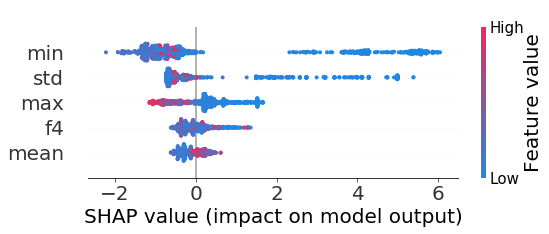

In [33]:
summary_plot(shap_values, X_res_test,feature_names = dv.feature_names,plot_type ='dot',max_display =5,title='feature importance')

In [34]:
# # sort the features indexes by their importance in the model
# # (sum of SHAP value magnitudes over the validation dataset)
# top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# # make SHAP plots of the three most important features
# for i in range(20):
#     shap.dependence_plot(top_inds[i], shap_values, X_res_test)